In [ ]:
'''
nparray+np.savez_compressed("t.npz", train_img=train_img) 
*read data from  /home/jmguo121/jm/MNIST_data/by_class/

np.vstack-->label(train_lbl, val_lbl) is int  -->to avoid, ValueError: could not convert string to float: 'J'

labels is --> 37-> 7
(
/by_class.zip係以hexadecimal ASCII representations命名影像資料夾，如4a-j,4b-k,30-0
37-> 7
/home/jmguo121/jm/MNIST_data/by_class/37/train_37/train_37_00505.png
)

image size=128x128

Training vs validation
/37/->77,704 個項目，大小為 51.0 MB
/37/train_37/ -->35,796 個項目，大小為 21.2 MB  ;;the suggested training set for OCR studies
37/hsf_4  --> 6,097 個項目，大小為 3.5 MB  ;; as a standard testing results reporting set
Training vs validation ，6 vs 1
(
The train_30 files contains the “0”s of all writers of partitions hsf_{0,1,2,3,6,7}. The
train_?? files comprise the suggested training set for OCR studies. The hsf_4 is likewise
earmarked as a standard testing results reporting set. Note that the class files are redundant
in this tree, since they contain only one unique hexadecimal class string, and the class has
already been indicated in the parent directory name. 
)

#train.npz,val.npz儲存影像,label,image mode & size 
'''
from glob import glob
from os.path import splitext
from PIL import Image

import numpy as np
import os
import urllib
import gzip
import struct
import matplotlib.pyplot as plt
import time

tStart = time.time()#計時開始

dataPath='/home/jmguo121/jm/MNIST_data/sd19_by_class/'   #sd-19 data path
#image(PngImageFile mode=RGB size=128x128 (0, 255))  resized into 28x28 with grayscale value between 0 and 254
rows, cols = 28, 28

def prepareData(dataPath,rows, cols):
        #將sd-19之train_,hsf_4資料夾png分別讀至一np array並存成壓縮檔sd-19train,sd-19val 
    train_img = np.zeros((rows, cols), dtype=np.float32)  #traning image for save npz file       
    train_lbl= np.zeros(1, dtype=np.int8)  #training label
    val_img= np.zeros((rows, cols), dtype=np.float32)   #validation image for save npz file 
    val_lbl= np.zeros(1, dtype=np.uint8)    #validation label

    pnglist = glob( dataPath+"*/*/*.png" ) 

    def rgb2gray(rgb):  #png 3chanel-> gray 1chanel
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray  
    
    #如果png影像之npz已存在
    try:
        data = np.load("train.npz") 
        train_img, train_lbl = data['train_img'], data['train_lbl'] 
        data = np.load("val.npz")
        val_img, val_lbl = data['val_img'], data['val_lbl'] 
        if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
            printprint("+npz壓縮檔有問題，將由sd19_by_clas夾讀取，並製作npz file")  
        else:  
            print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img:'+str(len(val_img)))
            return train_img, train_lbl, val_img, val_lbl
    except: 
        print("npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file")   
    

        #creat np array of image and label
    i=0 
    for png in pnglist: 
        if "train" in png:  #the suggested training set for OCR studies
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2) 
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel 
            train_img=np.vstack((train_img,im2))  #is need:(( ));im2 加在 train_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'   
            #train_lbl = np.vstack((train_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G';;training label
            train_lbl = np.append(train_lbl, int(i1, 16)) #training label;i1 加在train_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            i +=1
        elif "hsf_4" in png:    #validation data; hsf_4 standard testing set
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2)
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel
            val_img=np.vstack((val_img,im2))  #validation image;im2加在val_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'    
            #val_lbl = np.vstack((val_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G'
            val_lbl = np.append(val_lbl, int(i1, 16)) #validation label;i1加在val_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            i +=1 
            
        if((i%500)==0):
            print('已讀取：'+ str(i) +'---'+png[len(dataPath):len(png)]+'\r',end='')
 
    if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
        print("無資料")
        return 0
    #儲存影像,label,image mode & size
    print(len(train_lbl),train_lbl.shape, len(train_img),train_img.shape)
    #im={'mode':im2.mode,'size':im2.size}
    train_img=train_img.reshape((len(train_lbl),28, 28))
    train_img=np.delete(train_img, 0,0)  #del 空的初值
    train_lbl=np.delete(train_lbl, 0,0)  #del 空的初值
    val_img=val_img.reshape((len(val_lbl),28, 28))
    val_img=np.delete(val_img, 0,0)  #del 空的初值
    val_lbl=np.delete(val_lbl, 0,0)  #del 空的初值
    np.savez_compressed("train.npz", train_img=train_img, train_lbl=train_lbl)    
    np.savez_compressed("val.npz", val_img=val_img, val_lbl=val_lbl) 
    print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img1:'+str(len(val_img)))
    return train_img, train_lbl, val_img, val_lbl  

#將sd19之png images、labe、image mode & size等匯集成list
train_img, train_lbl, val_img, val_lbl = prepareData(dataPath, rows, cols)  
   
tEnd = time.time()#計時結束
m, s = divmod((tEnd - tStart), 60) 
h, m = divmod(m, 60) 
print('')
print ("it cost: %02d:%02d:%02d" % (h, m, s)) 

%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print(type(train_lbl),type(train_lbl[0]), train_lbl.shape,train_lbl[0:10])


import mxnet as mx
def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255
batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)


# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=62)  #num_hidden=10
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)


# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

tEnd = time.time()#計時結束
m, s = divmod((tEnd - tStart), 60) 
h, m = divmod(m, 60) 
print('')
print ("training cost: %02d:%02d:%02d" % (h, m, s)) 

In [ ]:
'''
nparray+np.savez_compressed("t.npz", train_img=train_img) 
*read data from  /home/jmguo121/jm/MNIST_data/by_class/

np.vstack-->label(train_lbl, val_lbl) is int  -->to avoid, ValueError: could not convert string to float: 'J'

labels is --> 37-> 7
(
/by_class.zip係以hexadecimal ASCII representations命名影像資料夾，如4a-j,4b-k,30-0
37-> 7
/home/jmguo121/jm/MNIST_data/by_class/37/train_37/train_37_00505.png
)

image size=128x128

Training vs validation
/37/->77,704 個項目，大小為 51.0 MB
/37/train_37/ -->35,796 個項目，大小為 21.2 MB  ;;the suggested training set for OCR studies
37/hsf_4  --> 6,097 個項目，大小為 3.5 MB  ;; as a standard testing results reporting set
Training vs validation ，6 vs 1
(
The train_30 files contains the “0”s of all writers of partitions hsf_{0,1,2,3,6,7}. The
train_?? files comprise the suggested training set for OCR studies. The hsf_4 is likewise
earmarked as a standard testing results reporting set. Note that the class files are redundant
in this tree, since they contain only one unique hexadecimal class string, and the class has
already been indicated in the parent directory name. 
)

#train.npz,val.npz儲存影像,label,image mode & size 
'''
from glob import glob
from os.path import splitext
from PIL import Image

import numpy as np
import os
import urllib
import gzip
import struct
import matplotlib.pyplot as plt
import time

tStart = time.time()#計時開始

dataPath='/home/jmguo121/jm/MNIST_data/sd19_by_class/'   #sd-19 data path
#image(PngImageFile mode=RGB size=128x128 (0, 255))  resized into 28x28 with grayscale value between 0 and 254
rows, cols = 28, 28

def prepareData(dataPath,rows, cols):
        #將sd-19之train_,hsf_4資料夾png分別讀至一np array並存成壓縮檔sd-19train,sd-19val 
    train_img = np.zeros((rows, cols), dtype=np.float32)  #traning image for save npz file       
    train_lbl= np.zeros(1, dtype=np.int8)  #training label
    val_img= np.zeros((rows, cols), dtype=np.float32)   #validation image for save npz file 
    val_lbl= np.zeros(1, dtype=np.uint8)    #validation label

    pnglist = glob( dataPath+"*/*/*.png" ) 

    def rgb2gray(rgb):  #png 3chanel-> gray 1chanel
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray  
    
    #如果png影像之npz已存在
    try:
        data = np.load("train.npz") 
        train_img, train_lbl = data['train_img'], data['train_lbl'] 
        data = np.load("val.npz")
        val_img, val_lbl = data['val_img'], data['val_lbl'] 
        if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
            printprint("+npz壓縮檔有問題，將由sd19_by_clas夾讀取，並製作npz file")  
        else:  
            print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img:'+str(len(val_img)))
            return train_img, train_lbl, val_img, val_lbl
    except: 
        print("npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file")   
    

        #creat np array of image and label
    i=0 
    for png in pnglist: 
        if "train" in png:  #the suggested training set for OCR studies
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2) 
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel 
            train_img=np.vstack((train_img,im2))  #is need:(( ));im2 加在 train_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'   
            #train_lbl = np.vstack((train_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G';;training label
            train_lbl = np.append(train_lbl, int(i1, 16)) #training label;i1 加在train_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            i +=1
        elif "hsf_4" in png:    #validation data; hsf_4 standard testing set
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2)
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel
            val_img=np.vstack((val_img,im2))  #validation image;im2加在val_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'    
            #val_lbl = np.vstack((val_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G'
            val_lbl = np.append(val_lbl, int(i1, 16)) #validation label;i1加在val_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            i +=1 
            
        if((i%500)==0):
            print('已讀取：'+ str(i) +'---'+png[len(dataPath):len(png)]+'\r',end='')
 
    if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
        print("無資料")
        return 0
    #儲存影像,label,image mode & size
    print(len(train_lbl),train_lbl.shape, len(train_img),train_img.shape)
    #im={'mode':im2.mode,'size':im2.size}
    train_img=train_img.reshape((len(train_lbl),28, 28))
    train_img=np.delete(train_img, 0,0)  #del 空的初值
    train_lbl=np.delete(train_lbl, 0,0)  #del 空的初值
    val_img=val_img.reshape((len(val_lbl),28, 28))
    val_img=np.delete(val_img, 0,0)  #del 空的初值
    val_lbl=np.delete(val_lbl, 0,0)  #del 空的初值
    np.savez_compressed("train.npz", train_img=train_img, train_lbl=train_lbl)    
    np.savez_compressed("val.npz", val_img=val_img, val_lbl=val_lbl) 
    print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img1:'+str(len(val_img)))
    return train_img, train_lbl, val_img, val_lbl  

#將sd19之png images、labe、image mode & size等匯集成list
train_img, train_lbl, val_img, val_lbl = prepareData(dataPath, rows, cols)  
   
tEnd = time.time()#計時結束
m, s = divmod((tEnd - tStart), 60)  
h, m = divmod(m, 60) 
print('')
print ("it cost: %02d:%02d:%02d" % (h, m, s)) 

npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file


In [6]:
import numpy as np
a=np.array([[1,2],[3,4]])
b=np.array([[5,6],[7,8]])
c=np.vstack((a,b))
c1=np.append(a,5)
print(c,c1)

[[1 2]
 [3 4]
 [5 6]
 [7 8]] [1 2 3 4 5]


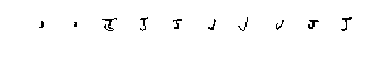

<class 'numpy.ndarray'> <class 'numpy.int64'> (3962,) [74 74 74 74 74 74 74 74 74 74]


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print(type(train_lbl),type(train_lbl[0]), train_lbl.shape,train_lbl[0:10])

In [27]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)


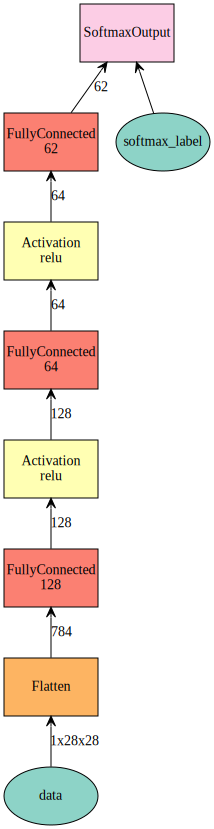

In [28]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=62)  #num_hidden=10
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [29]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=1.378
INFO:root:Epoch[0] Validation-accuracy=0.000000
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=1.003
INFO:root:Epoch[1] Validation-accuracy=0.000000
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=1.315
INFO:root:Epoch[2] Validation-accuracy=0.000000
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=1.333
INFO:root:Epoch[3] Validation-accuracy=0.000000
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.870
INFO:root:Epoch[4] Validation-accuracy=0.000000
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=1.158
INFO:root:Epoch[5] Validation-accuracy=0.000000
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.985
INFO:root:Epoch[6] Validation-accuracy=0.000000
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.839
INFO:root:Epoch[7] Validation-accuracy=0

In [1]:
'''
nparray+np.savez_compressed("t.npz", train_img=train_img) 
*read data from  /home/jmguo121/jm/MNIST_data/by_class/

np.vstack-->label(train_lbl, val_lbl) is int  -->to avoid, ValueError: could not convert string to float: 'J'

labels is --> 37-> 7
(
/by_class.zip係以hexadecimal ASCII representations命名影像資料夾，如4a-j,4b-k,30-0
37-> 7
/home/jmguo121/jm/MNIST_data/by_class/37/train_37/train_37_00505.png
)

image size=128x128

Training vs validation
/37/->77,704 個項目，大小為 51.0 MB
/37/train_37/ -->35,796 個項目，大小為 21.2 MB  ;;the suggested training set for OCR studies
37/hsf_4  --> 6,097 個項目，大小為 3.5 MB  ;; as a standard testing results reporting set
Training vs validation ，6 vs 1
(
The train_30 files contains the “0”s of all writers of partitions hsf_{0,1,2,3,6,7}. The
train_?? files comprise the suggested training set for OCR studies. The hsf_4 is likewise
earmarked as a standard testing results reporting set. Note that the class files are redundant
in this tree, since they contain only one unique hexadecimal class string, and the class has
already been indicated in the parent directory name. 
)

#train.npz,val.npz儲存影像,label,image mode & size 
'''
from glob import glob
from os.path import splitext
from PIL import Image

import numpy as np
import os
import urllib
import gzip
import struct
import matplotlib.pyplot as plt
import time

tStart = time.time()#計時開始

dataPath='/home/jmguo121/jm/MNIST_data/sd19_by_class/'   #sd-19 data path
#image(PngImageFile mode=RGB size=128x128 (0, 255))  resized into 28x28 with grayscale value between 0 and 254
rows, cols = 28, 28

def prepareData(dataPath,rows, cols):
        #將sd-19之train_,hsf_4資料夾png分別讀至一np array並存成壓縮檔sd-19train,sd-19val 
    train_img = np.zeros((rows, cols), dtype=np.float32)  #traning image for save npz file       
    train_lbl= np.zeros(1, dtype=np.int8)  #training label
    val_img= np.zeros((rows, cols), dtype=np.float32)   #validation image for save npz file 
    val_lbl= np.zeros(1, dtype=np.uint8)    #validation label

    pnglist = glob( dataPath+"4a/*/*.png" ) 

    def rgb2gray(rgb):  #png 3chanel-> gray 1chanel
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray 
 
    '''  
    #如果png影像之npz已存在
    try:
        data = np.load("train.npz") 
        train_img, train_lbl, im= data['train_img'], data['train_lbl'], data['im'].tolist()
        data = np.load("val.npz")
        val_img, val_lbl, im = data['val_img'], data['val_lbl'] , data['im'].tolist()
        if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[] or im==[]:
            printprint("+npz壓縮檔有問題，將由sd19_by_clas夾讀取，並製作npz file")  
        else: 
            # npz以bitstream 存image，so recovery by the oriange image mode and size 
 
            for i in range(len(train_img)):
                im1 = Image.new(im['mode'], im['size']) # Create a new image of the same oriange mode and size  
                im1.putdata(list(tuple(pixel) for pixel in train_img[i]))  #numpy array to list  
                train_img1.append(im1)   
                
            for i in range(len(val_img)):
                im1 = Image.new(im['mode'], im['size']) # Create a new image of the same oriange mode and size 
                im1.putdata(list(tuple(pixel) for pixel in train_img[i]))  #numpy array to list 
                val_img1.append(im1)  
   
            print('成功讀取npz file, training image：'+ str(len(train_img1))+', val_img1:'+str(len(val_img1)))
            return train_img1, train_lbl, val_img1, val_lbl, im
    except: 
        print("npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file")   
    '''  


        #creat np array of image and label
    i=0 
    for png in pnglist: 
        if "train" in png:  #the suggested training set for OCR studies
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2) 
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel 
            train_img=np.vstack((train_img,im2))  #is need:(( ))
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'   
            #train_lbl = np.vstack((train_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G';;training label
            train_lbl = np.vstack((train_lbl, int(i1, 16))) #training label;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
        elif "hsf_4" in png:    #validation data; hsf_4 standard testing set
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2)
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel
            val_img=np.vstack((val_img,im2))  #validation image
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'    
            #val_lbl = np.vstack((val_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G'
            val_lbl = np.vstack((val_lbl, int(i1, 16))) #validation label;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
        
        i +=1
        if((i%500)==0):
            print('已讀取：'+ str(i) +'---'+png[len(dataPath):len(png)]+'\r',end='')
 
    if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
        print("無資料")
        return 0
    #儲存影像,label,image mode & size
    print(len(train_lbl),train_lbl.shape, len(train_img),train_img.shape)
    #im={'mode':im2.mode,'size':im2.size}
    train_img=train_img.reshape((len(train_lbl),28, 28))
    train_img=np.delete(train_img, 0,0)  #del 空的初值
    train_lbl=np.delete(train_lbl, 0,0)  #del 空的初值
    val_img=val_img.reshape((len(val_lbl),28, 28))
    val_img=np.delete(val_img, 0,0)  #del 空的初值
    val_lbl=np.delete(val_lbl, 0,0)  #del 空的初值
    np.savez_compressed("train.npz", train_img=train_img, train_lbl=train_lbl)    
    np.savez_compressed("val.npz", val_img=val_img, val_lbl=val_lbl) 
    print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img1:'+str(len(val_img)))
    return train_img, train_lbl, val_img, val_lbl  

#將sd19之png images、labe、image mode & size等匯集成list
train_img, train_lbl, val_img, val_lbl = prepareData(dataPath, rows, cols)  
   
tEnd = time.time()#計時結束
m, s = divmod((tEnd - tStart), 60) 
h, m = divmod(m, 60) 
print('')
print ("it cost: %02d:%02d:%02d" % (h, m, s)) 

3963 (3963, 1) 110964 (110964, 28)g49.png


/home/jmguo121/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:118: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


成功讀取npz file, training image：3962, val_img1:426

it cost: 00:00:16
